In [94]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)
import collections
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
import datetime as dt
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import requests
import io

In [1]:
from math import log

In [170]:
df = pd.read_csv(r"C:\Users\01\Desktop\GENERAL_ACCES\howpop_train.csv")

In [171]:
df.drop(
    filter(lambda c: c.endswith("_lognorm"), df.columns),
    axis=1,  # axis = 1: столбцы
    inplace=True,
)  # избавляет от необходимости сохранять датасет

In [321]:
df

,url,domain,post_id,published,author,flow,polling,content_len,title,comments,favs,views,votes_plus,votes_minus,year,month,dayofweek,hour,year_month
0,https://habrahabr.ru/post/18284/,habrahabr.ru,18284,2008-01-01 18:19:00,@Tapac,develop,False,4305,Новогодний подарок блоггерам — WordPress 2.3.2,0,0,236,0.0,0.0,2008,1,2,18,2008-01-01
1,https://habrahabr.ru/post/18285/,habrahabr.ru,18285,2008-01-01 18:30:00,@DezmASter,design,False,7344,"Сумасшедшие яйца, или сервис для отслеживания ...",1,1,353,1.0,0.0,2008,1,2,18,2008-01-01
2,https://habrahabr.ru/post/18286/,habrahabr.ru,18286,2008-01-01 18:34:00,@DezmASter,design,False,8431,"Сумасшедшие яйца, или сервис для отслеживания ...",47,72,1200,45.0,5.0,2008,1,2,18,2008-01-01
3,https://habrahabr.ru/post/18291/,habrahabr.ru,18291,2008-01-02 01:32:00,@Taoorus,design,False,5662,"Сглаживание шрифтов, и субпиксельная отрисовка",102,36,5700,72.0,3.0,2008,1,3,1,2008-01-01
4,https://geektimes.ru/post/18294/,geektimes.ru,18294,2008-01-02 14:34:00,@dennydo,NaN,False,3706,Почему мне не нравится iPhone,230,6,1400,73.0,15.0,2008,1,3,14,2008-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134132,https://habrahabr.ru/company/mailru/blog/314014/,habrahabr.ru,314014,2016-10-31 21:45:00,NaN,develop,False,56033,Парсинг JSON — это минное поле,58,347,35500,164.0,6.0,2016,10,1,21,2016-10-01
134133,https://geektimes.ru/post/282086/,geektimes.ru,282086,2016-10-31 22:44:00,@marks,NaN,False,5504,Заработала система раннего предупреждения НАСА...,52,16,12900,22.0,0.0,2016,10,1,22,2016-10-01
134134,https://geektimes.ru/post/282090/,geektimes.ru,282090,2016-10-31 23:26:00,@Shapelez,NaN,False,2883,Арзамасский городской суд постановил заблокиро...,16,14,15800,28.0,4.0,2016,10,1,23,2016-10-01
134135,https://geektimes.ru/post/282092/,geektimes.ru,282092,2016-10-31 23:52:00,@ragequit,NaN,False,5735,Медиа-коммуникационный союз планирует внести в...,47,14,15000,20.0,0.0,2016,10,1,23,2016-10-01


In [3]:
# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (15, 5), "axes.titlesize": 18}
)

In [174]:
print(df.published.dtype)
df["published"] = pd.to_datetime(df.published, yearfirst=True)
print(df.published.dtype)

object
datetime64[ns]


In [176]:
df["year"] = [d.year for d in df.published]
df["month"] = [d.month for d in df.published]

df["dayofweek"] = [d.isoweekday() for d in df.published]
df["hour"] = [d.hour for d in df.published]

In [204]:
df['year_month'] = df.published.apply(lambda x: dt.datetime(x.year, x.month, 1))


In [205]:
df.head()

,url,domain,post_id,published,author,flow,polling,content_len,title,comments,favs,views,votes_plus,votes_minus,year,month,dayofweek,hour,year_month
0,https://habrahabr.ru/post/18284/,habrahabr.ru,18284,2008-01-01 18:19:00,@Tapac,develop,False,4305,Новогодний подарок блоггерам — WordPress 2.3.2,0,0,236,0.0,0.0,2008,1,2,18,2008-01-01
1,https://habrahabr.ru/post/18285/,habrahabr.ru,18285,2008-01-01 18:30:00,@DezmASter,design,False,7344,"Сумасшедшие яйца, или сервис для отслеживания ...",1,1,353,1.0,0.0,2008,1,2,18,2008-01-01
2,https://habrahabr.ru/post/18286/,habrahabr.ru,18286,2008-01-01 18:34:00,@DezmASter,design,False,8431,"Сумасшедшие яйца, или сервис для отслеживания ...",47,72,1200,45.0,5.0,2008,1,2,18,2008-01-01
3,https://habrahabr.ru/post/18291/,habrahabr.ru,18291,2008-01-02 01:32:00,@Taoorus,design,False,5662,"Сглаживание шрифтов, и субпиксельная отрисовка",102,36,5700,72.0,3.0,2008,1,3,1,2008-01-01
4,https://geektimes.ru/post/18294/,geektimes.ru,18294,2008-01-02 14:34:00,@dennydo,NaN,False,3706,Почему мне не нравится iPhone,230,6,1400,73.0,15.0,2008,1,3,14,2008-01-01


<AxesSubplot:xlabel='year_month'>

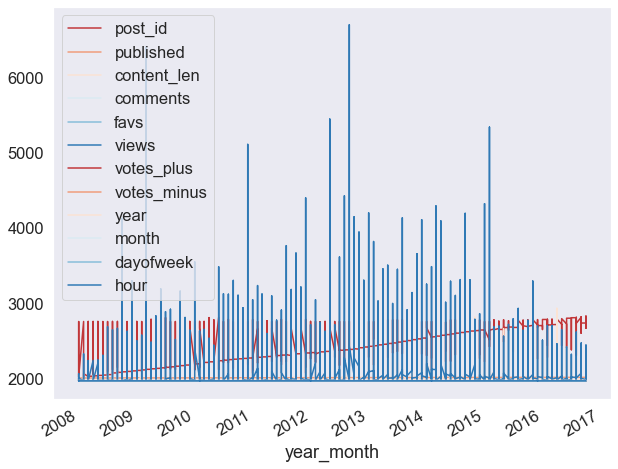

In [214]:
df.plot(x='year_month', )

<AxesSubplot:xlabel='day', ylabel='Count'>

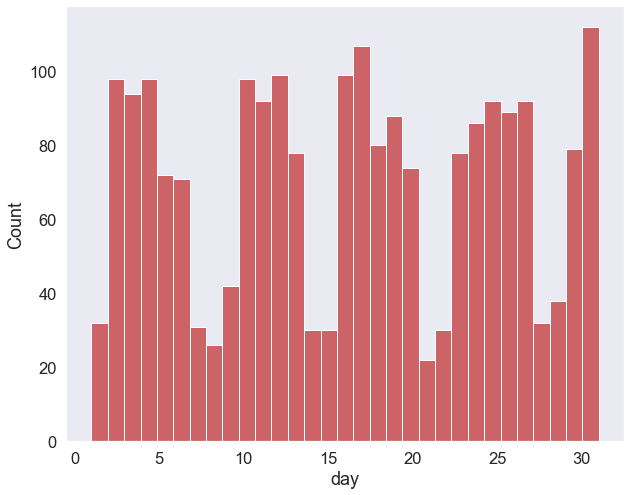

In [244]:
sns.histplot(march_2015_df.day, bins =31)

In [235]:
march_2015_df = df.loc[(df.year==2015)&(df.month==3)]

In [242]:
march_2015_df['day']=[d.day for d in march_2015_df.published]

C:\Users\01\AppData\Local\Temp/ipykernel_9808/1235951140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  march_2015_df['day']=[d.day for d in march_2015_df.published]


<AxesSubplot:xlabel='hour', ylabel='count'>

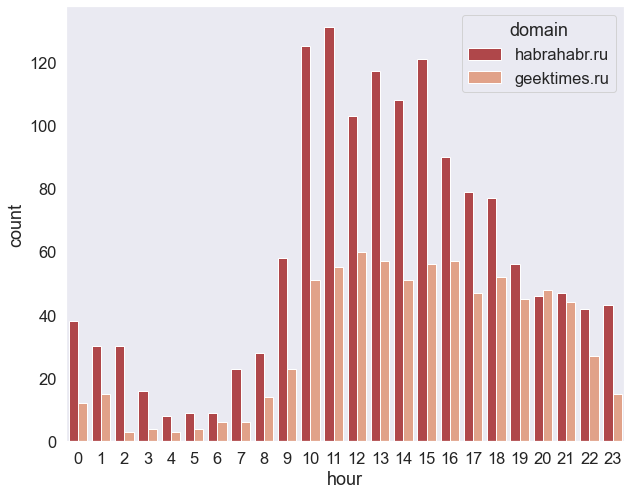

In [240]:
sns.countplot(hue = march_2015_df.domain, x =march_2015_df.hour)

<AxesSubplot:xlabel='hour', ylabel='comments'>

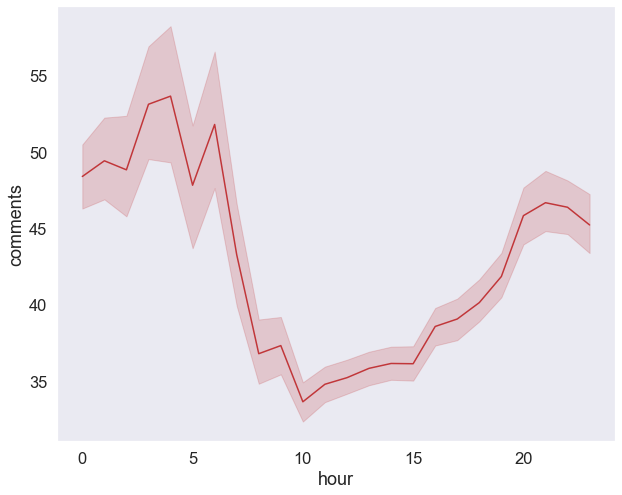

In [257]:
sns.lineplot(x=df.hour, y=df.comments)

In [329]:
new_df.groupby('author')['votes_minus'].sum()

author
@Jeditobe             2985.0
@Mithgol             11367.0
@Mordatyj             4057.0
@SLY_G                8293.0
@Shapelez             2770.0
@Sterhel              1786.0
@Tylerskald           2384.0
@XaocCPS              9111.0
@aleksandrit          6294.0
@alizar              41734.0
@andorro              3796.0
@atomlib              1988.0
@ilya42               3183.0
@ivansychev           3373.0
@jasiejames            323.0
@jeston               5117.0
@lozga                 484.0
@marks               18059.0
@ragequit             1784.0
@semen_grinshtein     1367.0
Name: votes_minus, dtype: float64

<AxesSubplot:xlabel='dayofweek', ylabel='count'>

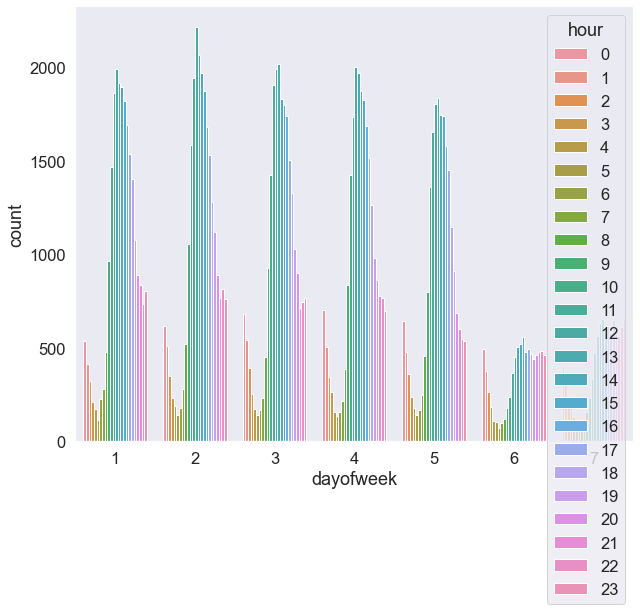

In [334]:
sns.countplot(x=df.dayofweek, hue=df.hour)

In [319]:
new_df = df[df['author'].isin(top_20)]

In [310]:
top_20 = [x[0] for x in top_20]

In [311]:
top_20 = top_20[1:]

In [330]:
df.dayofweek[1,7]

KeyError: 'key of type tuple not found and not a MultiIndex'

In [4]:
train_df = pd.read_csv(r"C:\Users\01\Desktop\GENERAL_ACCES\howpop_train.csv")
test_df = pd.read_csv(r"C:\Users\01\Desktop\GENERAL_ACCES\howpop_test.csv")

In [5]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


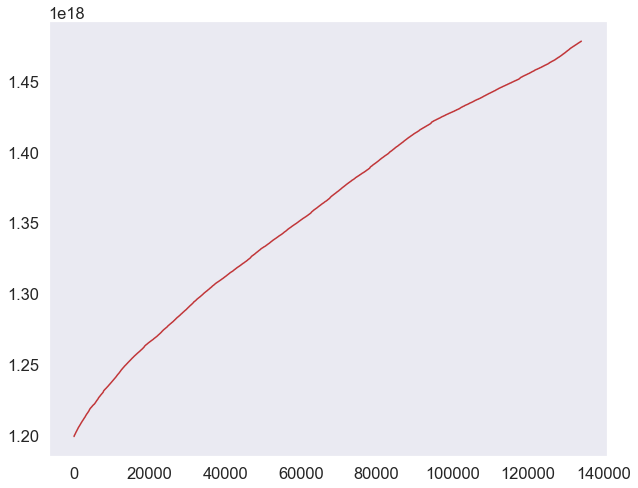

In [6]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

In [9]:
Counter(train_df.corr() >0.9)

Counter({'post_id': 1,
         'polling': 1,
         'content_len': 1,
         'comments': 1,
         'favs': 1,
         'views': 1,
         'votes_plus': 1,
         'votes_minus': 1,
         'views_lognorm': 1,
         'favs_lognorm': 1,
         'comments_lognorm': 1})

array([[<AxesSubplot:title={'center':'year'}>]], dtype=object)

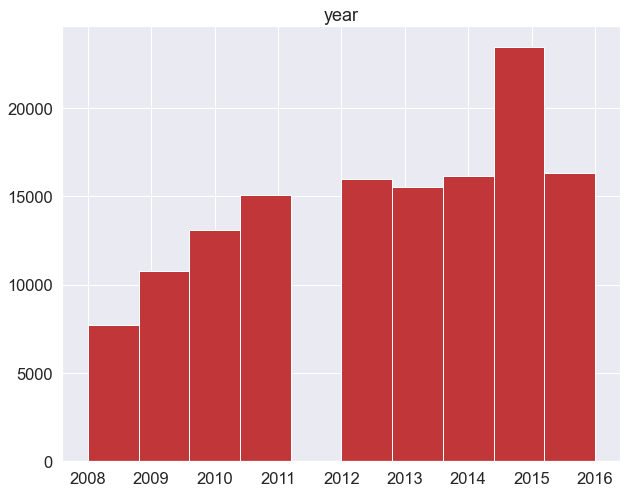

In [16]:
train_df.hist(column='year')

In [15]:
train_df["year"] = [d.year for d in train_df.published]

In [14]:
train_df["published"] = pd.to_datetime(train_df.published, yearfirst=True)

In [18]:
train_df.drop('year', inplace=True, axis=1)

In [19]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [20]:
len(train_df), train_size

(134137, 93895)

In [21]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.loc[:, features]

In [22]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

In [45]:
vectorizer_title = TfidfVectorizer(max_df=0.3, min_df=3, ngram_range=(1,3))

X_train_title = vectorizer_title.fit_transform(X_train['title'])
X_valid_title = vectorizer_title.transform(X_valid['title'])
X_test_title = vectorizer_title.transform(X_test['title'])



In [42]:
vectorizer_title.vocabulary_

{'новогодний': 31497,
 'подарок': 36257,
 'блоггерам': 14241,
 'wordpress': 12172,
 'новогодний подарок': 31499,
 'сумасшедшие': 45476,
 'яйца': 50489,
 'или': 22661,
 'сервис': 42745,
 'для': 18811,
 'отслеживания': 34225,
 'посетителей': 37373,
 'или сервис': 22833,
 'сервис для': 42751,
 'для отслеживания': 19413,
 'или сервис для': 22834,
 'сервис для отслеживания': 42753,
 'сглаживание': 42460,
 'шрифтов': 49862,
 'отрисовка': 34214,
 'сглаживание шрифтов': 42461,
 'почему': 37632,
 'мне': 28231,
 'не': 30755,
 'нравится': 31925,
 'iphone': 5951,
 'почему мне': 37659,
 'мне не': 28233,
 'не нравится': 30851,
 'всеобщая': 16456,
 'доступность': 20285,
 'действии': 18272,
 'чем': 49165,
 'суть': 45504,
 'проекта': 39310,
 'ru': 9541,
 'search': 9842,
 'запускается': 21584,
 'понедельник': 37201,
 'mobile': 7315,
 'выбор': 16759,
 'способа': 44575,
 'связи': 42437,
 'обзор': 32095,
 'под': 36147,
 'windows': 11973,
 'под windows': 36185,
 'онлайн': 33063,
 'банкинг': 13661,
 'оформле

In [49]:
vectorizer_title_ch = TfidfVectorizer(analyzer='word')

X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
X_test_title_ch = vectorizer_title_ch.transform(X_test['title'])



In [50]:
len(vectorizer_title_ch.vocabulary_)

77566

In [51]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


In [52]:
# сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [53]:
# Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
# а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [54]:
# В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
# поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [55]:
# В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [56]:
# Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [57]:
# В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
# Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

In [58]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


In [59]:
# например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

In [63]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train[feats].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid[feats].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test[feats].fillna('-').T.to_dict().values())


In [62]:
feats

['author', 'flow', 'domain']

In [66]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

In [70]:
%%time
model1 = Ridge(alpha=0.1, random_state=1)

model1.fit(X_train_new, y_train)

Wall time: 6.27 s


Ridge(alpha=0.1, random_state=1)

In [73]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds1))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds1))

Ошибка на трейне 0.06477075935535041
Ошибка на тесте 0.9665806097247602


In [74]:
%%time
model2 = Ridge(alpha=1, random_state=1)

model2.fit(X_train_new, y_train)

Wall time: 2.14 s


Ridge(alpha=1, random_state=1)

In [75]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds2))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds2))

Ошибка на трейне 0.2049947630116395
Ошибка на тесте 0.720462176986002


In [77]:
big_train = scipy.sparse.vstack([X_train_new,X_valid_new])

In [78]:
big_train

<134137x146059 sparse matrix of type '<class 'numpy.float64'>'
	with 2190799 stored elements in COOrdinate format>

In [87]:
%%time
model1 = Ridge(alpha=0.1, random_state=1)

model1.fit(big_train, y)

test_preds = model1.predict(X_test_new)

Wall time: 11.6 s


In [84]:
y = y_train.append(y_valid)

In [80]:
X_train_new

<93895x146059 sparse matrix of type '<class 'numpy.float64'>'
	with 1521736 stored elements in COOrdinate format>

In [85]:
y

0        -1.344075
1        -0.831946
2         1.794023
3         1.300050
4         0.961094
            ...   
134132    2.124862
134133   -0.511814
134134   -0.656390
134135   -0.655385
134136   -0.290955
Name: favs_lognorm, Length: 134137, dtype: float64

In [90]:
r= requests.get(r'https://github.com/Yorko/mlcourse.ai/blob/main/data/habr_sample_submission.csv').content

In [97]:
sample_submission = pd.read_csv(r'https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/habr_sample_submission.csv', 
                                index_col='url')

In [98]:
sample_submission

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754
...,...
https://geektimes.ru/post/281642/,0.109585
https://habrahabr.ru/company/tuturu/blog/320326/,0.513478
https://habrahabr.ru/company/gemaltorussia/blog/320214/,0.857914


In [99]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds
# это будет бейзлайн "Простое решение"
ridge_submission.to_csv(r'C:\Users\01\Desktop\GENERAL_ACCES\ridge_baseline.csv') 